O conjunto de dados Cora é comumente usado em tarefas de classificação de documentos. Ele é composto por citações científicas e cada documento é representado como uma bag-of-words binária. O desafio com Cora é que ele não é um modelo de embeddings de palavras, como o GloVe ou o FastText. Em vez disso, é um conjunto de dados de documentos.

Se você deseja usar o conjunto de dados Cora para criar embeddings, você terá que treinar um modelo nele. Uma abordagem popular para isso é usar o método Graph Neural Networks (GNNs) ou Graph Convolutional Networks (GCNs) para aprender representações vetoriais dos documentos.

Passos principais:

    Carregar o conjunto de dados Cora: Isso envolve carregar os documentos e o gráfico de citação.

    Treinar um GCN: Usando o gráfico de citação e os recursos dos documentos (bag-of-words binária), você pode treinar um GCN para aprender embeddings para cada documento.

    Gerar Embeddings para Títulos: Depois de treinar o GCN, você pode usá-lo para gerar embeddings para qualquer documento no conjunto de dados Cora.

Para implementar um GCN com PyTorch, você provavelmente usaria uma biblioteca como o PyTorch Geometric. Treinar um GCN é um processo mais envolvido do que simplesmente carregar embeddings pré-treinados como o GloVe.

# Instalando o PyTorch Geometric

In [ ]:
# !python -m venv pytorch
# !pytorch\Scripts\activate

# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html

# !pip install torch-geometric

In [ ]:
# import runpy

# # Carrega as funções diretamente do arquivo pytorch_checks.py
# check_pytorch = runpy.run_path('../../../../utils/pytorch_checks.py')['check_pytorch']
# check_gpu = runpy.run_path('../../../../utils/pytorch_checks.py')['check_gpu']


In [ ]:
# import importlib.util

# # Especifique o caminho completo para o arquivo pytorch_checks.py
# path = '../../../../utils/pytorch_checks.py'

# # Carrega as funções diretamente do arquivo pytorch_checks.py
# spec = importlib.util.spec_from_file_location("pytorch_checks", path)
# pytorch_checks = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(pytorch_checks)

# check_pytorch = pytorch_checks.check_pytorch
# check_gpu = pytorch_checks.check_gpu

## Conjunto de dados Cora
O conjunto de dados Cora é um conjunto de dados bem conhecido no campo da pesquisa de grafos. Este consiste em 2708 publicações científicas classificadas em uma das sete classes. A rede de citações consiste em 5429 links. Cada publicação no conjunto de dados é descrita por um vetor de palavra com valor 0/1 indicando a ausência/presença da palavra correspondente no dicionário. O dicionário consiste em 1433 palavras únicas.

# Avaliando instalação PyTorch e GPU

In [1]:
import sys
sys.path.append('../../../../utils')

from pytorch_checks import check_pytorch, check_gpu
check_pytorch()
check_gpu()

PyTorch version: 2.0.1+cu118
PyTorch Geometric version: 2.3.1
GPU is available
GPU Device Name: NVIDIA GeForce RTX 2060
CUDA Version: 11.8


device(type='cuda')

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

# Carregando o conjunto de dados Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

In [3]:
# Informações básicas sobre o conjunto de dados
print("Número de classes:", dataset.num_classes)
print("Número de recursos por nó:", dataset.num_node_features)
print("Número de nós no conjunto de treinamento:", len(dataset[0].y))
print("Número de arestas no conjunto de treinamento:", dataset[0].edge_index.shape[1])

Número de classes: 7
Número de recursos por nó: 1433
Número de nós no conjunto de treinamento: 2708
Número de arestas no conjunto de treinamento: 10556


In [4]:
import numpy as np
# Exibindo as classes do conjunto de dados
data = dataset[0]

unique_classes = np.unique(data.y.numpy())
print("Classes presentes no conjunto de dados Cora:")
print(unique_classes)

Classes presentes no conjunto de dados Cora:
[0 1 2 3 4 5 6]


In [5]:
# https://keras.io/examples/graph/gnn_citations/

label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

# Explorando o Cora Dataset

In [ ]:
import collections
import matplotlib.pyplot as plt
import seaborn as sns

counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

In [ ]:
print(f'Número de nós: {data.num_nodes}')
print(f'Número de arestas: {data.num_edges}') 

print(f'Tem nós isolados: {data.has_isolated_nodes()}') # False 
print(f'Tem auto-loops: {data.has_self_loops()}') # False 
print(f'É não direcionado: {data.is_undirected ()}') # Verdadeiro

print(f'Grau médio: {data.num_edges / data.num_nodes:.2f}') 
# Average node degree: 3.90

In [ ]:
edge_index = data.edge_index.numpy() 
print(edge_index.shape) 
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]] 
edge_example

In [ ]:
import networkx as nx

node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6)) 
G = nx.Graph() 
G.add_nodes_from(node_example) 
G.add_edges_from(list(zip(edge_example[0], edge_example[1]))) 
nx.draw_networkx(G , with_labels=False)

In [ ]:
import pandas as pd
from torch_geometric.utils import to_networkx

# import torch
# from torch import Tensor
# import torch_geometric
# from torch_geometric.datasets import Planetoid

G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

In [ ]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

# Definir o modelo

In [6]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [8]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        acc = correct / data.test_mask.sum().item()
    return acc

In [9]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, val_losses, val_accuracies):
    epochs = range(0, len(train_losses))

    plt.figure(figsize=(12, 4))

    # Plot da perda de treinamento e validação
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve - Loss')
    plt.legend()

    # Plot da acurácia de validação
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve - Validation Accuracy')
    plt.legend()

    plt.tight_layout()

# Treinar o modelo nos dados desejados

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

# Loop de treinamento
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Avaliar o desempenho do modelo durante o treinamento
    if epoch % 10 == 0:
        acc = evaluate(model, data)
        train_losses.append(loss.item())
        val_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
        val_losses.append(val_loss.item())
        val_accuracies.append(acc)
        
        # Plotar em tempo real
        clear_output(wait=True)
        plot_learning_curve(train_losses, val_losses, val_accuracies)
        plt.show()

        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')


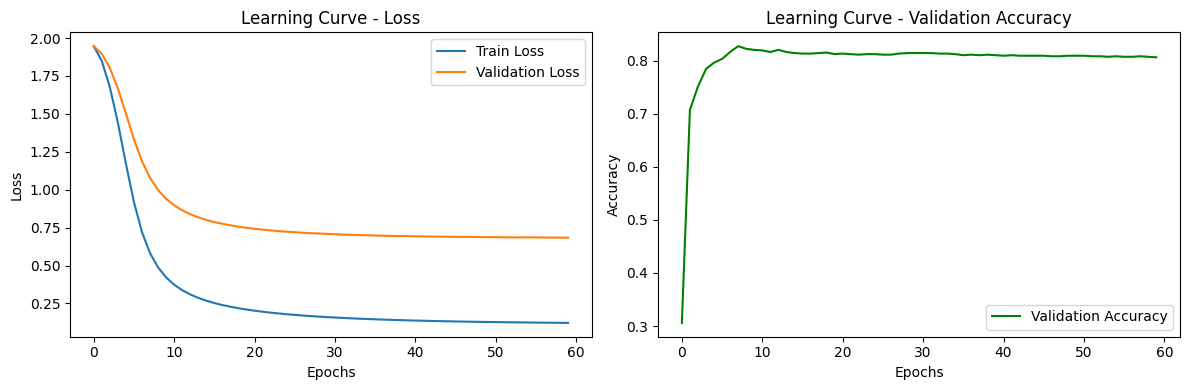

Epoch 590, Loss: 0.1217, Accuracy: 0.8060


In [10]:
train_losses = []
val_losses = []
val_accuracies = []

# Loop de treinamento
for epoch in range(600):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Avaliar o desempenho do modelo durante o treinamento
    if epoch % 10 == 0:
        acc = evaluate(model, data)
        train_losses.append(loss.item())
        val_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
        val_losses.append(val_loss.item())
        val_accuracies.append(acc)
        
        # Plotar em tempo real
        clear_output(wait=True)
        plot_learning_curve(train_losses, val_losses, val_accuracies)
        plt.show()

        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

In [ ]:
import torch

# Limpar a memória da GPU
torch.cuda.empty_cache()


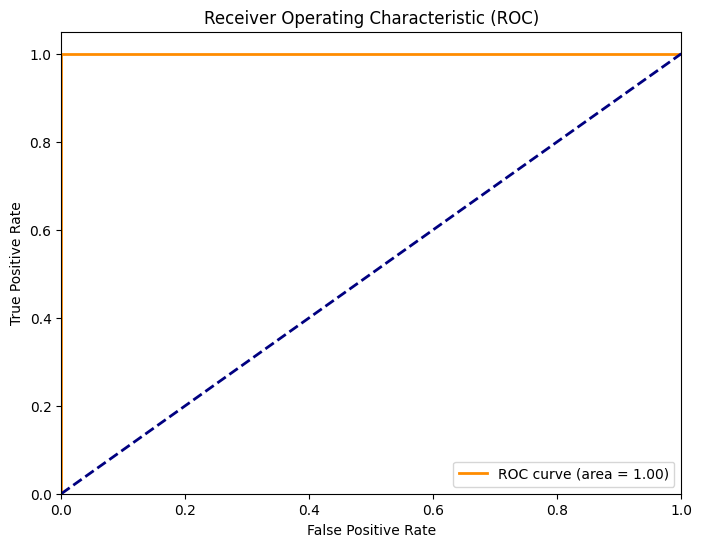

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Exemplo de dados
y_true = [0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
y_scores = [0.1, 0.2, 0.7, 0.8, 0.6, 0.3, 0.5, 0.4, 0.9, 0.85]

# Calcula a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plota a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, val_losses, val_accuracies):
    """
    Plota a curva de aprendizado com perda de treinamento, perda de validação e acurácia de validação.
    
    Args:
        train_losses (list): Lista das perdas de treinamento em cada época.
        val_losses (list): Lista das perdas de validação em cada época.
        val_accuracies (list): Lista das acurácias de validação em cada época.
    """
    epochs = range(0, len(train_losses))
    
    plt.figure(figsize=(12, 4))

    # Plot da perda de treinamento e validação
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve - Loss')
    plt.legend()

    # Plot da acurácia de validação
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve - Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exemplo de uso
train_losses = [1.5, 1.2, 0.8, 0.6, 0.4]
val_losses = [1.3, 1.0, 0.7, 0.5, 0.3]
val_accuracies = [0.75, 0.80, 0.85, 0.88, 0.90]

plot_learning_curve(train_losses, val_losses, val_accuracies)

Essa função plota a perda de treinamento e validação em um gráfico, além de uma segunda plotagem com a acurácia de validação. A separação em duas subplots permite que você visualize a evolução da perda e da acurácia de forma mais clara.

Ao analisar a curva de aprendizado, observa-se os seguintes pontos:

    Perda de Treinamento e Validação: 
    
    - Uma perda de treinamento muito baixa em comparação com a perda de validação pode indicar overfitting, enquanto uma perda alta em ambos os casos pode indicar underfitting.

    Acurácia de Validação: 
    
    - Uma curva de acurácia crescente indica que o modelo está aprendendo e melhorando. Uma estagnação ou queda na acurácia de validação pode indicar overfitting.

A interpretação da curva de aprendizado pode variar dependendo da natureza do problema, dos dados e da configuração do modelo. Portanto, é importante analisar a curva com cuidado e fazer ajustes conforme necessário.

Mas, em linhas gerais, um bom aprendizado para o modelo é caracterizado por um comportamento específico nas curvas de aprendizado ao longo das épocas. Aqui estão os padrões que você deve observar para determinar se o seu modelo está aprendendo de maneira adequada:

1. **Perda de Treinamento e Validação:**
   - A perda de treinamento deve diminuir consistentemente ao longo das épocas. Isso indica que o modelo está se ajustando aos dados de treinamento e melhorando a sua capacidade de fazer previsões precisas.
   - A perda de validação deve diminuir inicialmente, mas pode começar a se estabilizar ou até mesmo aumentar ligeiramente. Isso é esperado à medida que o modelo começa a se ajustar aos detalhes específicos do conjunto de treinamento e pode começar a generalizar menos bem para dados novos. No entanto, uma diferença significativa entre a perda de treinamento e a perda de validação indica overfitting, enquanto valores altos para ambas podem indicar underfitting.

2. **Acurácia de Validação:**
   - A acurácia de validação deve aumentar consistentemente à medida que o modelo aprende a fazer previsões melhores.
   - Assim como a perda de validação, a acurácia pode começar a se estabilizar ou aumentar mais lentamente à medida que o modelo se ajusta aos dados de treinamento.
   - Se a acurácia de treinamento continuar a aumentar enquanto a acurácia de validação começa a cair ou se estabiliza, isso sugere overfitting, pois o modelo está se tornando muito especializado nos dados de treinamento.

Em resumo, um bom aprendizado é caracterizado por uma perda de treinamento em queda, uma perda de validação que diminui inicialmente e depois se estabiliza, e uma acurácia de validação crescente. É importante observar a relação entre a perda de treinamento e a perda de validação, bem como a taxa de crescimento da acurácia de validação, para avaliar se o modelo está encontrando um bom equilíbrio entre aprender com os dados de treinamento e generalizar para dados novos.

In [ ]:
def get_vector(title):
    # Aqui, o processo é mais complicado, pois você precisa converter seu título em um formato aceitável pelo modelo
    # e depois passá-lo pelo GCN para obter um embedding. 
    pass
